# COVID-19 in Brazil
***

In this notebook, I'll be analyzing SARS-CoV-2 (also know as Coronavirus or COVID-19) in Brazil. I'll be exploring:
* National data, 
* Epidemiological data,
* State data,
* Regional data.

And with the whole data, there will be a lot of visualizations (following charting and plotting standards by Albert Cairo and Edward Tufte).

The main dataset for this notebook comes from [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/). Consider visiting their platform and contribute with the project.

## Importations and Initial Setup

Necessary setup like lib importations, macros, chart style settings and others.

### Importations

All the libraries will be used during the notebook runtime.

In [114]:
## Needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random
import csv
import gzip
import io
import time
from urllib.request import Request, urlopen

### Initial settings

Important macros and settings that will be used during the whole notebook.

In [115]:
## Saving today's date

today = datetime.date.today().strftime("%Y-%m-%d")
yesterday = (datetime.date.today() - datetime.timedelta(days = 1)).strftime('%Y-%m-%d')
today = yesterday

## Creating a list from the first case until today

date_list = pd.date_range(start = "2020-02-25", end = today)

## Creating a dictionary of regions and states

region_list = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]

regions = {
    "Norte" : ["AC", "AP", "AM", "TO", "PA", "RR", "RO"],
    "Nordeste" : ["AL", "BA", "PB", "PE", "SE", "PI", "CE", "MA", "RN"],
    "Centro-Oeste" : ["MT", "GO", "MS", "DF"],
    "Sudeste" : ["SP", "ES", "RJ", "MG"],
    "Sul" : ["SC", "RS", "PR"]
}

In [116]:
## Defining Matplotlib's backend

%matplotlib inline

In [117]:
## Defining the style for plottings

plt.style.use("seaborn-whitegrid")

In [118]:
## Global customizations for plotting

# Figure

plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] = 600

# Axes

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.labelweight'] = 600
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.titleweight'] = 600
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'

# Ticks

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Grid

plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.4

# Minor

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['lines.linewidth'] = 2

## Utility Functions

### Save dataset

In [119]:
## Function used to save DataFrames into CSV datasets

def save_dataset(dataset, path):
    return dataset.to_csv(path, index=False)

In [120]:
## Function to create a report of the daily updated data

def generate_report(dataset):
    file = open(f"reports/{today[5:7]}-{today[0:4]}/report_{today[-2:]}{today[5:7]}{today[0:4]}.txt", "w", encoding='utf8')
    
    file.write(f"Atualização COVID-19 no Brasil [{today[-2:]}/{today[5:7]}/{today[0:4]}]\n")
    
    file.write(("Casos Acumulados: {0:,}\n").format(dataset["accumulated_num_cases"].iat[-1]).replace(',','.'))
    file.write(("Óbitos Acumulados: {0:,}\n\n").format(dataset["accumulated_num_deaths"].iat[-1]).replace(',','.'))
   
    file.write(("Qntd. de NOVOS Casos: {0:,}\n").format(dataset["new_num_cases"].iat[-1]).replace(',','.'))
    file.write(("Qntd. de NOVOS Óbitos: {0:,}\n\n").format(dataset["new_num_deaths"].iat[-1]).replace(',','.'))
    
    file.write("Fonte dos dados: http://brasil.io / Secretarias de Saúde\n")
    file.write("#ficaemcasa #DataScience #COVID19")
    
    file.close()

In [121]:
## Function to get a region name based on input (state)

def get_region(state):
    for region, states in regions.items():  
        if state in states:
            return region

## Data Preprocessing
***

In this section I'll be downloading and cleasing the dataset. It must be said that, in order to explore data completely I'll be splitting the dataset into minor and more specific ones, such as:

* National dataset
* Regional datasets (one dataset for each region)

To get reading easier I'll go in the order said before.

### Getting the data

Dataset used can be downloaded in [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/). **IMPORTANT!** Without the work of Brazil.IO this notebook wouldn't be possible. So consider visiting and contributing to their project.

In [122]:
## Function to download and save the dataset

def download_dataset():
    
    # Downloads the dataset from request/response
    request = Request("https://data.brasil.io/dataset/covid19/caso_full.csv.gz", headers={"User-Agent": "python-urllib"})
    response = urlopen(request)
    
    # Create a DataFrame from dictionary
    dataset = pd.DataFrame.from_dict(csv.DictReader(io.StringIO(gzip.decompress(response.read()).decode("utf-8"))))
    
    # Saves the dataset
    save_dataset(dataset, "data/covid19-dataset-brasil-io.csv")
    
    # Returns the reading of the saved dataset (This process it's necessary in order to avoid type errors and possible errors during data reading)
    return pd.read_csv("data/covid19-dataset-brasil-io.csv")

### Cleaning the main dataset

In [123]:
def data_cleaning(dataset):
    
    # List of columns that will be droped
    columns_to_drop = ["city", "city_ibge_code", "estimated_population_2019", "is_last", "is_repeated", "last_available_confirmed_per_100k_inhabitants", "last_available_death_rate", "order_for_place", "place_type"]
    
    # Droping the columns and resetting the indexes;
    dataset = (dataset[~dataset["place_type"].isin(["city"])]
                .drop(columns_to_drop, axis=1)
                .reset_index(drop=True))
    
    # Adding the "Region" column (refer to the getRegion utility function)
    dataset['region'] = list(map(get_region, dataset.state.tolist()))
    
    # Reordering and renaming columns
    dataset = (dataset[['date', 'last_available_date', 'region', 'state', 'epidemiological_week', 'last_available_confirmed', 'last_available_deaths', 'new_confirmed', 'new_deaths']]
               .rename(columns={"last_available_confirmed": "accumulated_cases",
                                 "new_confirmed": "new_cases",
                                 "last_available_deaths": "accumulated_deaths",
                                 "new_deaths": "new_deaths",
                                }))
    # Saving the updated dataset
    save_dataset(dataset, "data/covid19-dataset-brasil-io_original.csv")
    save_dataset(dataset, "data/covid19-dataset-brasil-io.csv")
    
    return dataset

### National Dataset

In [124]:
## Function used to get/process information about the whole country (Brazil)

def process_national_data(dataset):
    
    # Creating auxiliary lists
    acc_cases = []
    acc_deaths = []
    n_cases = []
    n_deaths = []
    epi_week = []
    
    # Iterating over each date
    for date in date_list:
        
        # Summing over all data for specific date
        summatory = dataset[dataset['date'] == date.strftime("%Y-%m-%d")].sum()
        
        # Getting the epidemiological week for each date
        epi_week.append(dataset[dataset['date'] == date.strftime("%Y-%m-%d")].epidemiological_week.iat[0])
        
        # Getting summed data of each column
        acc_cases.append(summatory[5])
        acc_deaths.append(summatory[6])
        n_cases.append(summatory[7])
        n_deaths.append(summatory[8])
    
#     # Saving the dataset
#     save_dataset(dataset, "data/covid19-dataset-brasil-io.csv")
    
    # Creating a new DataFrame of the processed data
    national_dataframe = pd.DataFrame({"date": date_list, 
                                       "country": "Brazil", 
                                       "epidemiological_week": epi_week, 
                                       "accumulated_num_cases": acc_cases, 
                                       "accumulated_num_deaths": acc_deaths,
                                       "new_num_cases": n_cases,
                                       "new_num_deaths": n_deaths
                                      })
    
    # Saving the dataset
    save_dataset(national_dataframe, "data/covid19-dataset-brasil-io.csv")
    
    # Returning generated DataFrame
    return national_dataframe

### Regional Dataset

In [125]:
def process_regional_data(dataset):
    
    # Creating a global list (scope)
    dataframe_list = []
    
    # Iterating over each region
    for region in region_list:
        
        # Creating auxiliary lists
        acc_cases = []
        acc_deaths = []
        n_cases = []
        n_deaths = []
        
        # Specifying the dataset
        temp_dataset = dataset[dataset["region"] == region]
        
        # Iterating over each date
        for date in date_list:
            
            # Summing over all data for specific date
            summatory = temp_dataset[temp_dataset['date'] == date.strftime("%Y-%m-%d")].sum()
            
            # Getting summed data of each column
            acc_cases.append(summatory[5])
            acc_deaths.append(summatory[6])
            n_cases.append(summatory[7])
            n_deaths.append(summatory[8])
        
        # Generating a new DataFrame for each region and storing at r_data
        dataframe_list.append(pd.DataFrame({"date": date_list,
                                            "region": region,
                                            "accumulated_num_cases": map(int, acc_cases),
                                            "accumulated_num_deaths": map(int, acc_deaths),
                                            "new_num_cases": map(int, n_cases),
                                            "new_num_deaths": map(int, n_deaths)
                                           }))
    
    # Batch dataset saving
    for index, region in enumerate(region_list):
        save_dataset(dataframe_list[index], (f"data/covid19-{region}.csv"))
    
    # Returning a list of 5 DataFrames
    dataframe_list = pd.concat([dataframe_list[0], dataframe_list[1], dataframe_list[2], dataframe_list[3], dataframe_list[4]])
    
    return dataframe_list

## Data Visualization

### National Charts

In [126]:
def plot_national_acc(dataset):
    
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)
    
    # Customizing the figure
    fig.autofmt_xdate(rotation=0, ha='center')
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Números de casos e óbitos acumulados de COVID-19 no Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.5, .12, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)
    
    # Adding data to the axis
    axs[0].plot(dataset["date"], dataset["accumulated_num_cases"], label = "Casos Acumulados")
    axs[1].plot(dataset["date"], dataset["accumulated_num_deaths"], label = "Óbitos Acumulados", color='red')
    
    # Customizing the axis
    axs[0].set_title("Número de casos confirmados (acumulados)", fontsize=14)
    axs[1].set_title("Número de óbitos confirmados (acumulados)", fontsize=14)
    axs[0].set_xlabel("Data")
    axs[1].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_ylabel("Nº de Óbitos")
    axs[1].tick_params(axis='x', which='both', length=5, width=1.5, color='lightgray')
    
    # For each axis apply ->
    for ax in axs:
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))
        ax.legend(prop=dict(weight='bold'))
        ax.yaxis.get_major_formatter().set_scientific(False)
        
    # Annotations
    axs[0].annotate('{0:,}'.format(dataset["accumulated_num_cases"].iat[-1]).replace(',','.'), 
                    (dataset["date"].iat[-1], dataset["accumulated_num_cases"].iat[-1]), 
                    textcoords = "offset points", xytext=(20, -3), 
                    fontweight = 600, color='black', 
                    arrowprops=dict(color='black', arrowstyle='wedge'), fontsize=12)
    
    axs[1].annotate('{0:,}'.format(dataset["accumulated_num_deaths"].iat[-1]).replace(',','.'), 
                    (dataset["date"].iat[-1], dataset["accumulated_num_deaths"].iat[-1]), 
                    textcoords = "offset points", xytext=(20, -3), 
                    fontweight = 600, color='black', 
                    arrowprops=dict(color='black', arrowstyle='wedge'), fontsize=12)
        
    # Saving the chart
    plt.savefig("images/01_national_acc.png")
    
    return plt.show()

In [127]:
def plot_national_daily(dataset):
    
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)
    
    # Customizing the figure
    fig.autofmt_xdate(rotation=0, ha='center')
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Números de casos e óbitos diários de COVID-19 no Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.5, .12, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)
    
    # Adding data to the axis
    axs[0].plot(dataset["date"], dataset["new_num_cases"], label = "Casos Diários")
    axs[1].plot(dataset["date"], dataset["new_num_deaths"], label = "Óbitos Diários", color='red')
    
    # Customizing the axis
    axs[0].set_title("Número de casos confirmados (diários)", fontsize=14)
    axs[1].set_title("Número de óbitos confirmados (diários)", fontsize=14)
    axs[0].set_xlabel("Data")
    axs[1].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_ylabel("Nº de Óbitos")
    axs[1].tick_params(axis='x', which='both', length=5, width=1.5, color='lightgray')
    
    # For each axis apply ->
    for ax in axs:
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))
        ax.legend(prop=dict(weight='bold'))
        ax.yaxis.get_major_formatter().set_scientific(False)
        
    # Annotations
    axs[0].annotate('{0:,}'.format(dataset["new_num_cases"].iat[-1]).replace(',','.'), 
                    (dataset["date"].iat[-1], dataset["new_num_cases"].iat[-1]), 
                    textcoords = "offset points", xytext=(20, -3), 
                    fontweight = 600, color='black', 
                    arrowprops=dict(color='black', arrowstyle='wedge'), fontsize=12)
    
    axs[1].annotate('{0:,}'.format(dataset["new_num_deaths"].iat[-1]).replace(',','.'), 
                    (dataset["date"].iat[-1], dataset["new_num_deaths"].iat[-1]), 
                    textcoords = "offset points", xytext=(20, -3), 
                    fontweight = 600, color='black', 
                    arrowprops=dict(color='black', arrowstyle='wedge'), fontsize=12)
    
    # Saving the chart
    plt.savefig("images/02_national_new.png")
    
    return plt.show()

### Epidemiological Charts

In [128]:
def plot_epidemiological_weeks(dataset):
    
    # Shortcuts for nice plotting
    weeks = dataset["epidemiological_week"].unique()
    n_cases = [dataset[dataset["epidemiological_week"] == week].new_num_cases.sum() for week in weeks]
    n_deaths = [dataset[dataset["epidemiological_week"] == week].new_num_deaths.sum() for week in weeks]
      
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)

    # Customizing the figure
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Número de Casos e Óbitos de COVID-19 p/ Semana Epidemiológica no Brasil")
    fig.text(.43, .075, ("Semana atual: " + str(dataset["epidemiological_week"].iat[-1])[-2:] + " de " + today[0:4]), fontsize=14, fontweight="bold")
    fig.text(.5, .05, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)

    # Adding data to the axis (accumulated cases/deaths)  
    axs[0].bar(range(len(weeks)), n_cases, align='center')
    axs[1].bar(range(len(weeks)), n_deaths, align='center', color="red")
    
    # Customizing axis
    axs[0].set_title("Número de casos p/ semana")
    axs[0].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_title("Número de óbitos p/ semana")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("Nº de Óbitos")
    axs[0].set_xticks(range(len(weeks)))
    axs[0].set_xticklabels([(str(week)[-2:] + "-" + str(week)[:4]) for week in list(weeks)])
    axs[1].set_xticks(range(len(weeks)))
    axs[1].set_xticklabels([(str(week)[-2:] + "-" + str(week)[:4]) for week in list(weeks)])
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
    axs[0].tick_params(axis='x', which='both', length=5, width=1.5, color='lightgray')
    axs[1].tick_params(axis='x', which='both', length=5, width=1.5, color='lightgray')

    # Saving the chart
    plt.savefig("images/03_epidemiological_weeks.png")
    
    return plt.show()

### State Charts

In [129]:
def plot_state_acc(dataset):
    
    # Specifying the dataset for today
    dataset = dataset[dataset["date"] == today]
    
    # Generating an annotation
    not_updated = dataset[dataset["last_available_date"] != today].state.tolist()
    str_upd = ""
    for state in not_updated:
        str_upd += ("%s " % (state))
        
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)

    # Customizing the figure
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Número de Casos e Óbitos acumulados de COVID-19 nos Estados do Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.35, .08, ("Estados ainda não atualizados: " + str_upd), fontsize=12)
    fig.text(.5, .05, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)
    
    # Adding data to the axis (accumulated cases/deaths)
    axs[0].bar(dataset["state"], dataset["accumulated_cases"], color="#1F77B4", align='center')
    axs[1].bar(dataset["state"], dataset["accumulated_deaths"], color="red", align='center')
    
    # Customizing axis
    axs[0].set_title("Número de casos confirmados (acumulados)")
    axs[0].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_title("Número de óbitos confirmados (acumulados)")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("Nº de Óbitos")
    
    # For each axis apply ->
    for ax in axs:
        ax.yaxis.set_major_locator(plt.MaxNLocator(20))
        ax.yaxis.get_major_formatter().set_scientific(False)
    
    # Saving the chart
    plt.savefig("images/04_state_acc.png")
    
    return plt.show()

In [130]:
def plot_state_daily(dataset):
    
    # Specifying the dataset for today
    dataset = dataset[dataset["date"] == today]
    
    # Generating an annotation
    not_updated = dataset[dataset["last_available_date"] != today].state.tolist()
    str_upd = ""
    for state in not_updated:
        str_upd += ("%s " % (state))
        
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)

    # Customizing the figure
    fig.subplots_adjust(top=0.92)
    fig.suptitle("Número de Casos e Óbitos de HOJE de COVID-19 nos Estados do Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.35, .08, ("Estados ainda não atualizados: " + str_upd), fontsize=12)
    fig.text(.5, .05, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)
    
    # Adding data to the axis (accumulated cases/deaths)
    axs[0].bar(dataset["state"], dataset["new_cases"], color="#1F77B4", align='center')
    axs[1].bar(dataset["state"], dataset["new_deaths"], color="red", align='center')
    
    # Customizing axis
    axs[0].set_title("Número de casos confirmados (diário)")
    axs[0].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_title("Número de óbitos confirmados (diário)")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("Nº de Óbitos")
    
    # For each axis apply ->
    for ax in axs:
        ax.yaxis.set_major_locator(plt.MaxNLocator(20))
        ax.yaxis.get_major_formatter().set_scientific(False)
    
    # Saving the chart
    plt.savefig("images/05_state_new.png")
    
    return plt.show()

### Regional Charts

In [131]:
def plot_regional_acc(dataset):
    
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)

    # Customizing the figure
    fig.subplots_adjust(top=0.92)
    fig.autofmt_xdate(rotation=0, ha='center')
    fig.suptitle("Número de Casos e Óbitos acumulados de COVID-19 nas Regiões do Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.5, .09, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)

    # Adding data to the axis (accumulated cases/deaths)
    for index in range(0, len(region_list)):
        regional_dataset = dataset[dataset["region"] == region_list[index]]
        axs[0].plot(regional_dataset["date"], regional_dataset["accumulated_num_cases"], label = ("Região " + region_list[index]))
        axs[1].plot(regional_dataset["date"], regional_dataset["accumulated_num_deaths"], label = ("Região " + region_list[index]))

    # Customizing axis
    axs[0].set_title("Número de casos confirmados (acumulados)")
    axs[0].set_xlabel("Data")
    axs[0].set_ylabel("Nº de Casos")
    axs[1].set_title("Número de óbitos confirmados (acumulados)")
    axs[1].set_xlabel("Data")
    axs[1].set_ylabel("Nº de Óbitos")
    
    # For each axis apply ->
    for ax in axs:
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.legend(prop=dict(weight='bold'))
    
    # Saving the chart
    plt.savefig("images/06_regional_acc.png")
    
    return plt.show()

In [132]:
def plot_regional_daily(dataset):
    
    # Specifying the regional data to today's date
    dataset = dataset[dataset["date"] == today]
    
    # Gathering number of new cases and new deaths
    n_cases = list(dataset.new_num_cases)
    n_deaths = list(dataset.new_num_deaths)
    
    # Creating the figure
    fig, axs = plt.subplots(2, 1, figsize=(12, 14), dpi=100)

    # Customizing the figure
    fig.subplots_adjust(top=0.92)
    fig.autofmt_xdate(rotation=0, ha='center')
    fig.suptitle("Número de Casos e Óbitos de HOJE de COVID-19 nas Regiões do Brasil até %s/%s/%s" % (today[-2:], today[5:7], today[0:4]))
    fig.text(.5, .09, "Autor: Evandro Rodrigues | Fonte: Brasil.IO em: %s/%s/%s" % (today[-2:], today[5:7], today[0:4]), ha='center', fontsize="14", fontweight=600)

    # Adding data to the axis
    axs[0].pie(list(map(lambda x: (x / sum(n_cases)) * 100, n_cases)), labels=region_list, autopct='%1.2f%%', shadow=False, startangle=90, textprops=dict(fontweight="bold", fontsize=12))
    axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[1].pie(list(map(lambda x: (x / sum(n_deaths)) * 100, n_deaths)), labels=region_list, autopct='%1.2f%%', shadow=False, startangle=90, textprops=dict(fontweight="bold", fontsize=12))
    axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Customizing axis
    axs[0].set_title("Número de casos confirmados (diário)")  
    axs[1].set_title("Número de óbitos confirmados (diário)")
 
    # For each axis apply ->
    for ax in axs:
        ax.legend(prop=dict(weight='bold'))
    
    # Saving the chart
    plt.savefig("images/07_regional_new.png")
    
    return plt.show()

## Main

In [133]:
def main():
    print("=== COVID 19 - BRAZIL ===\n")
    print("> Downloading the dataset (caso_full.csv) from | data.brasil.io/dataset/covid19/ |")
    
    covid_dataset = download_dataset()
    
    print("  - Download completed.\n")
    print("> Initiating dataset cleaning.")
    
    covid_dataset = data_cleaning(covid_dataset)
    
    print("  - Data cleaning completed.\n")
    print("> Processing national data.")
    
    national_data = process_national_data(covid_dataset)
    
    print("  - National data acquired.\n")
    print("> Processing regional data.")
    
    regional_data = process_regional_data(covid_dataset)
    
    print("  - Regional data acquired.\n")
    print("> Generating plots.")
    
    plot_national_acc(national_data)
    plot_national_daily(national_data)
    plot_epidemiological_weeks(national_data)
    plot_state_acc(covid_dataset)
    plot_state_daily(covid_dataset)
    plot_regional_acc(regional_data)
    plot_regional_daily(regional_data)
    
    print("  - Plots generated.\n")
    print("> Returning dataframes.")
    print("  - DataFrames returned.\n")
    
    print("> Generating report")
    
    generate_report(national_data)
    
    print("  - Report generated.\n")
    
    print("Exiting the application.\n")
    
    return covid_dataset, national_data, regional_data

=== COVID 19 - BRAZIL ===

> Downloading the dataset (caso_full.csv) from | data.brasil.io/dataset/covid19/ |
  - Download completed.

> Initiating dataset cleaning.
  - Data cleaning completed.

> Processing national data.
  - National data acquired.

> Processing regional data.
  - Regional data acquired.

> Generating plots.


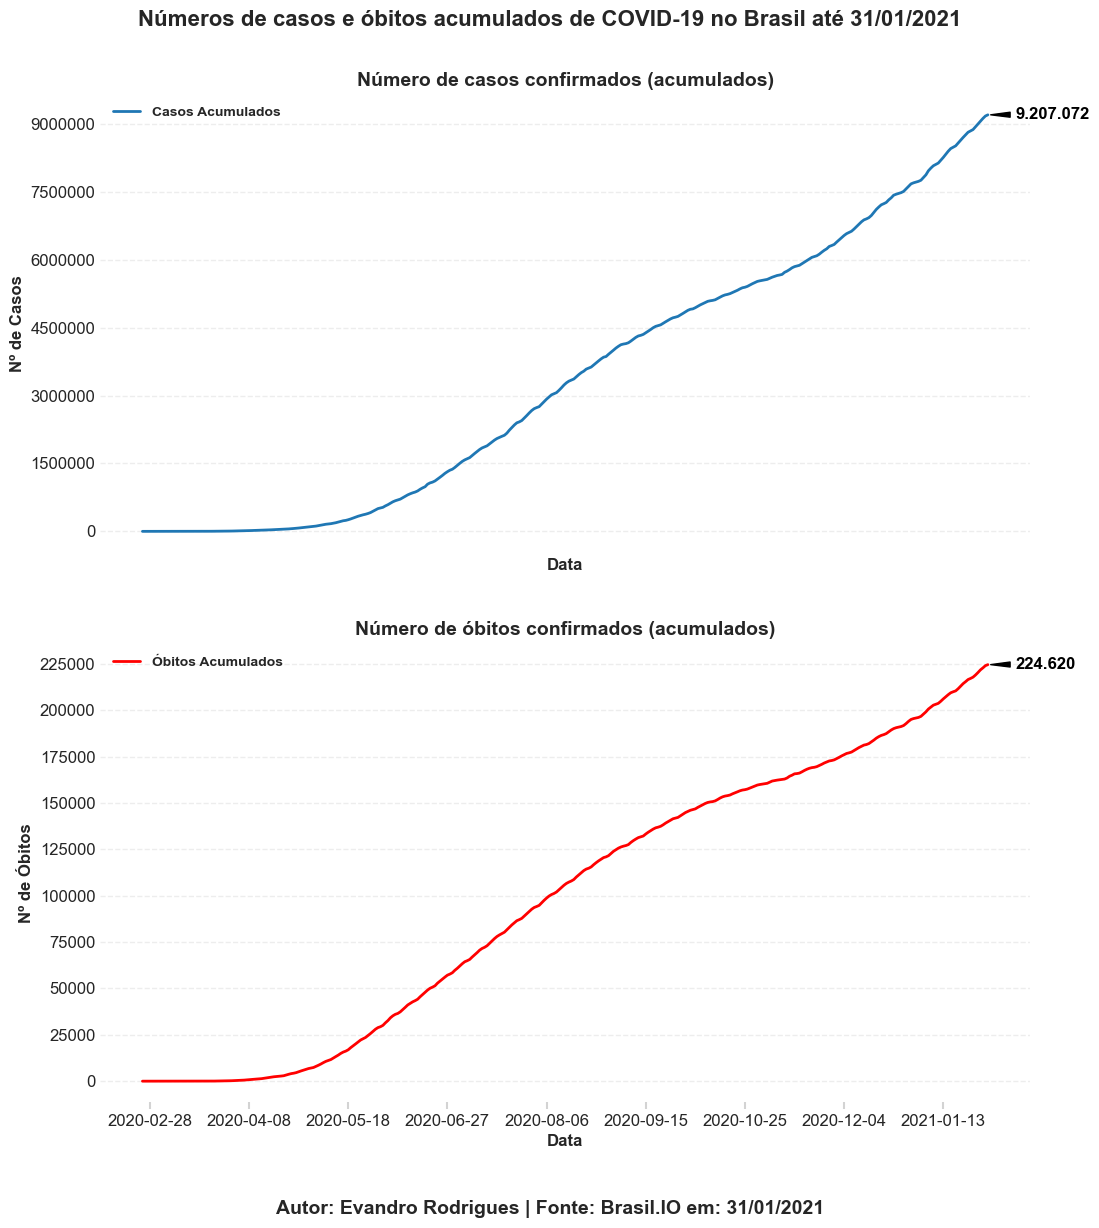

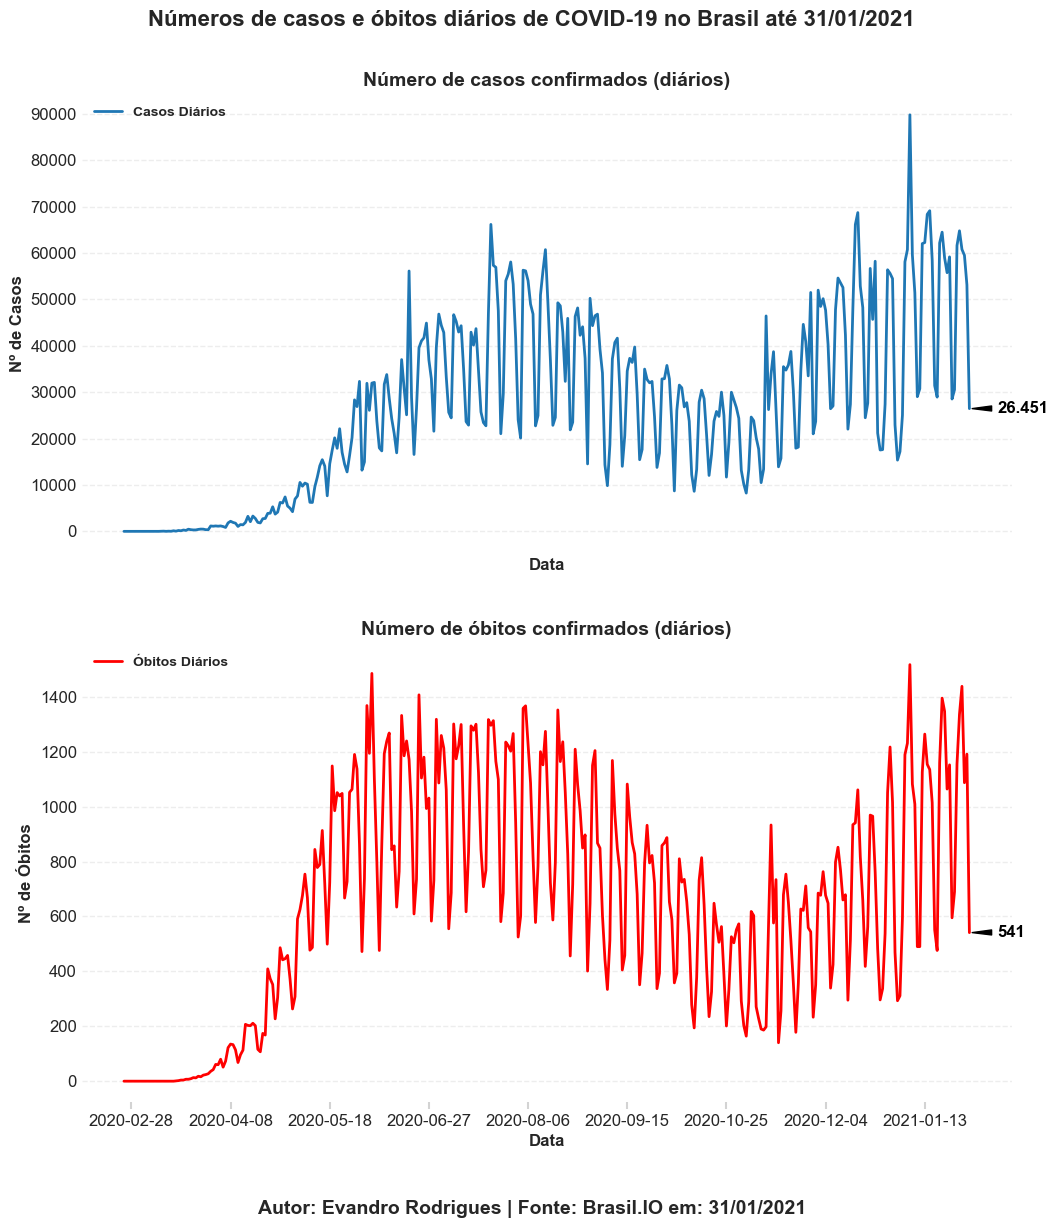

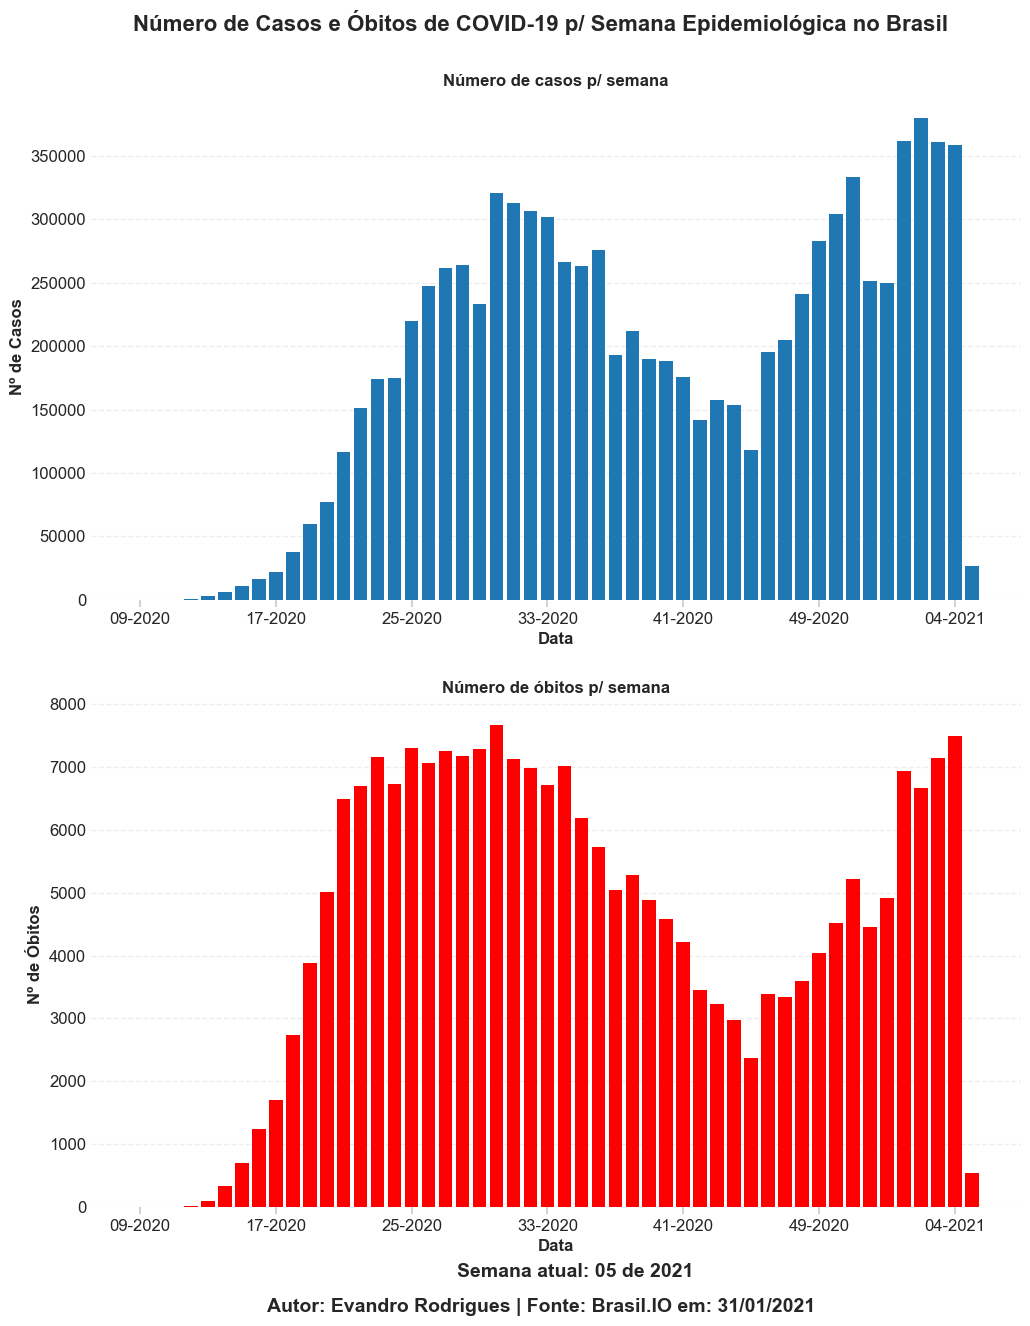

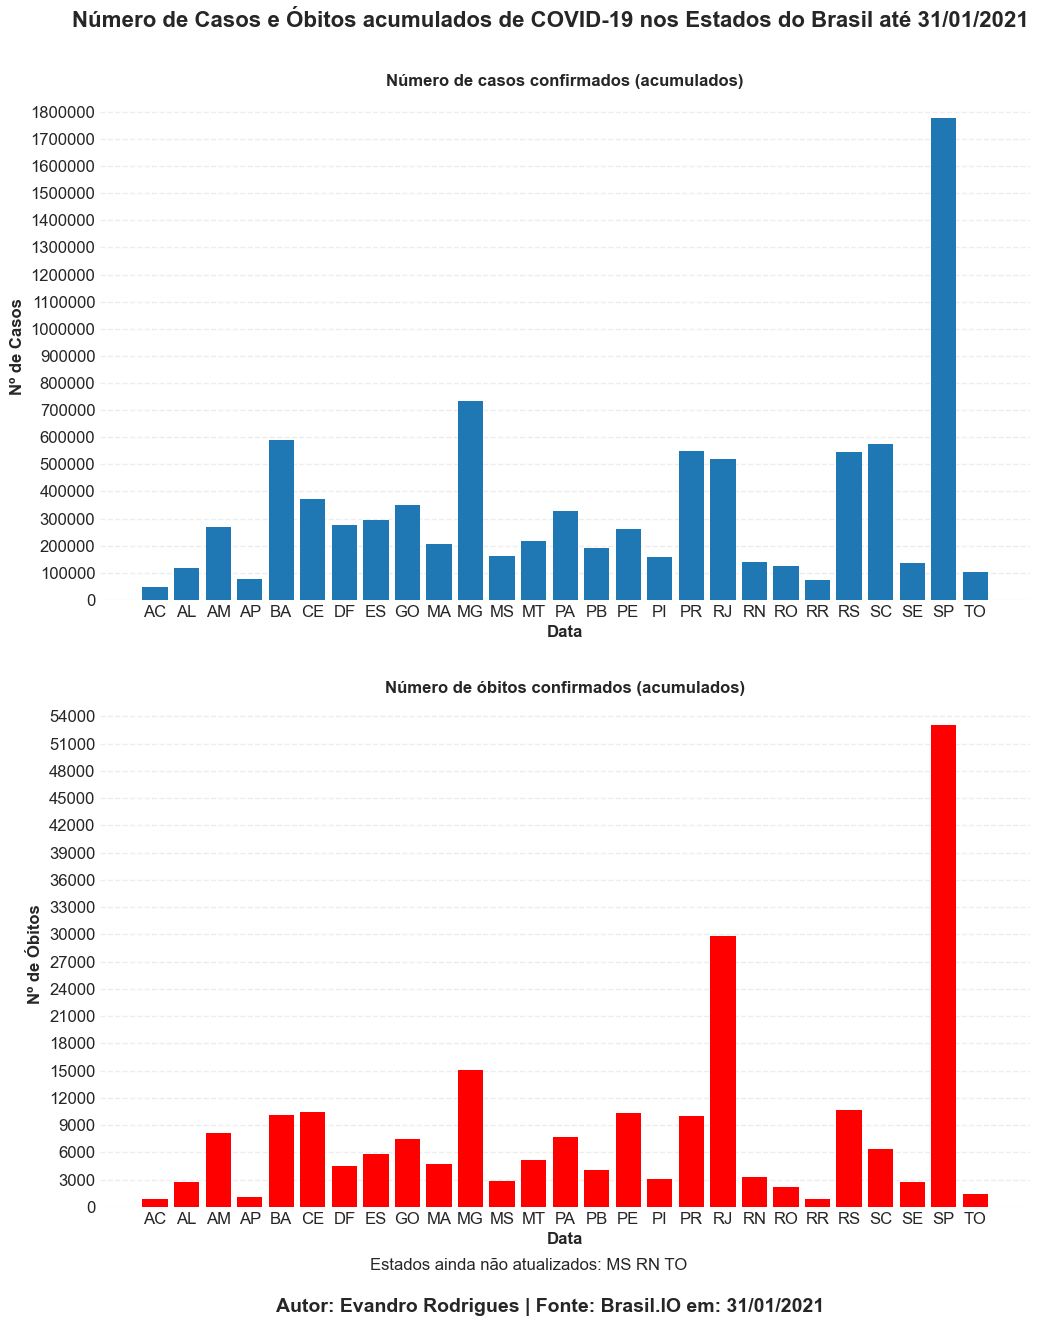

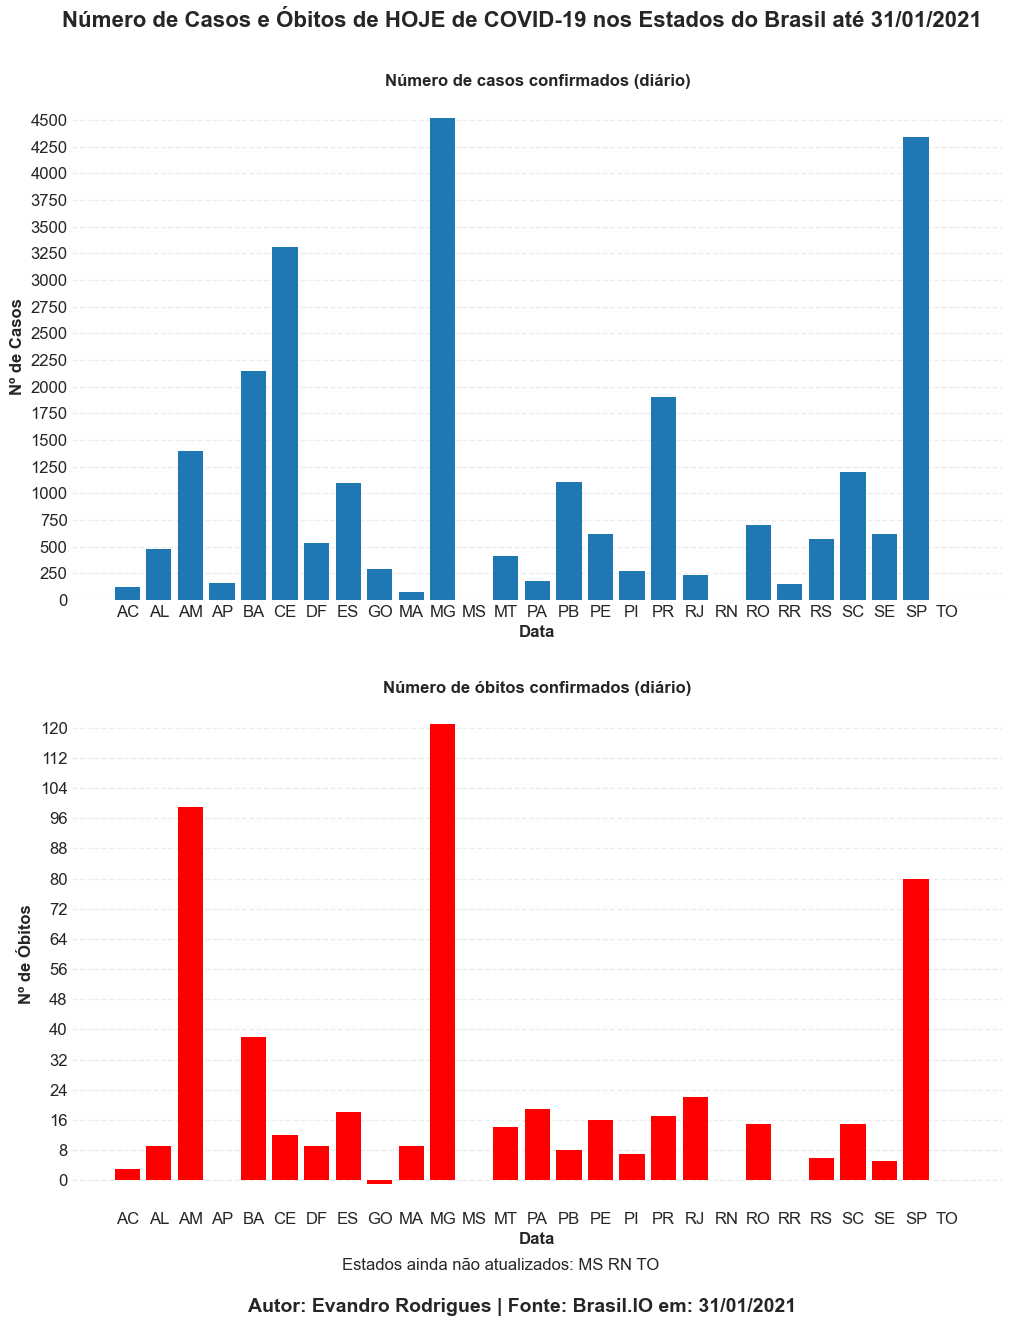

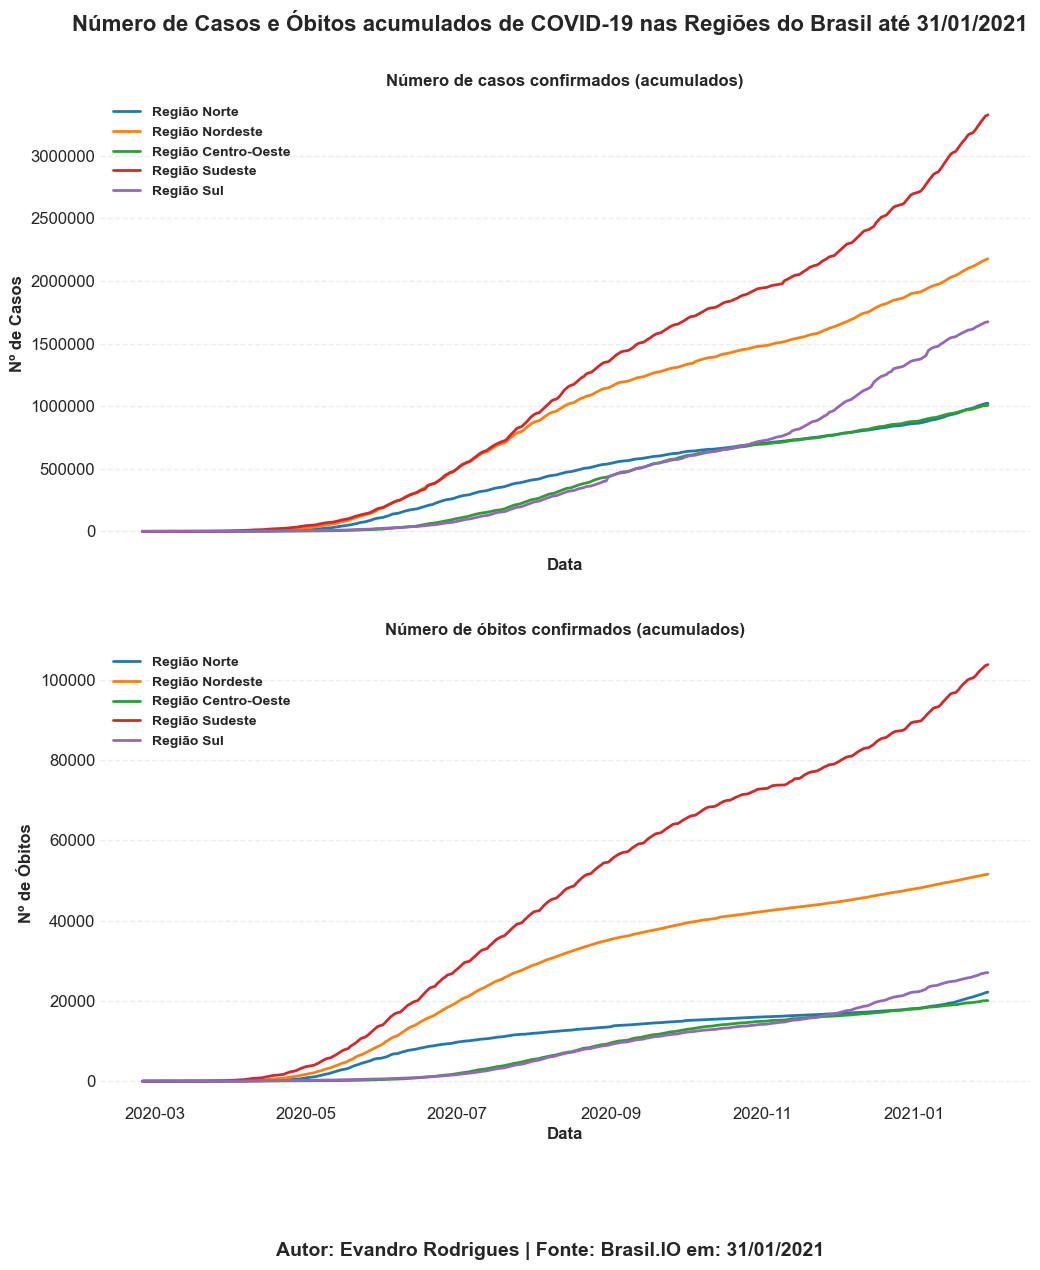

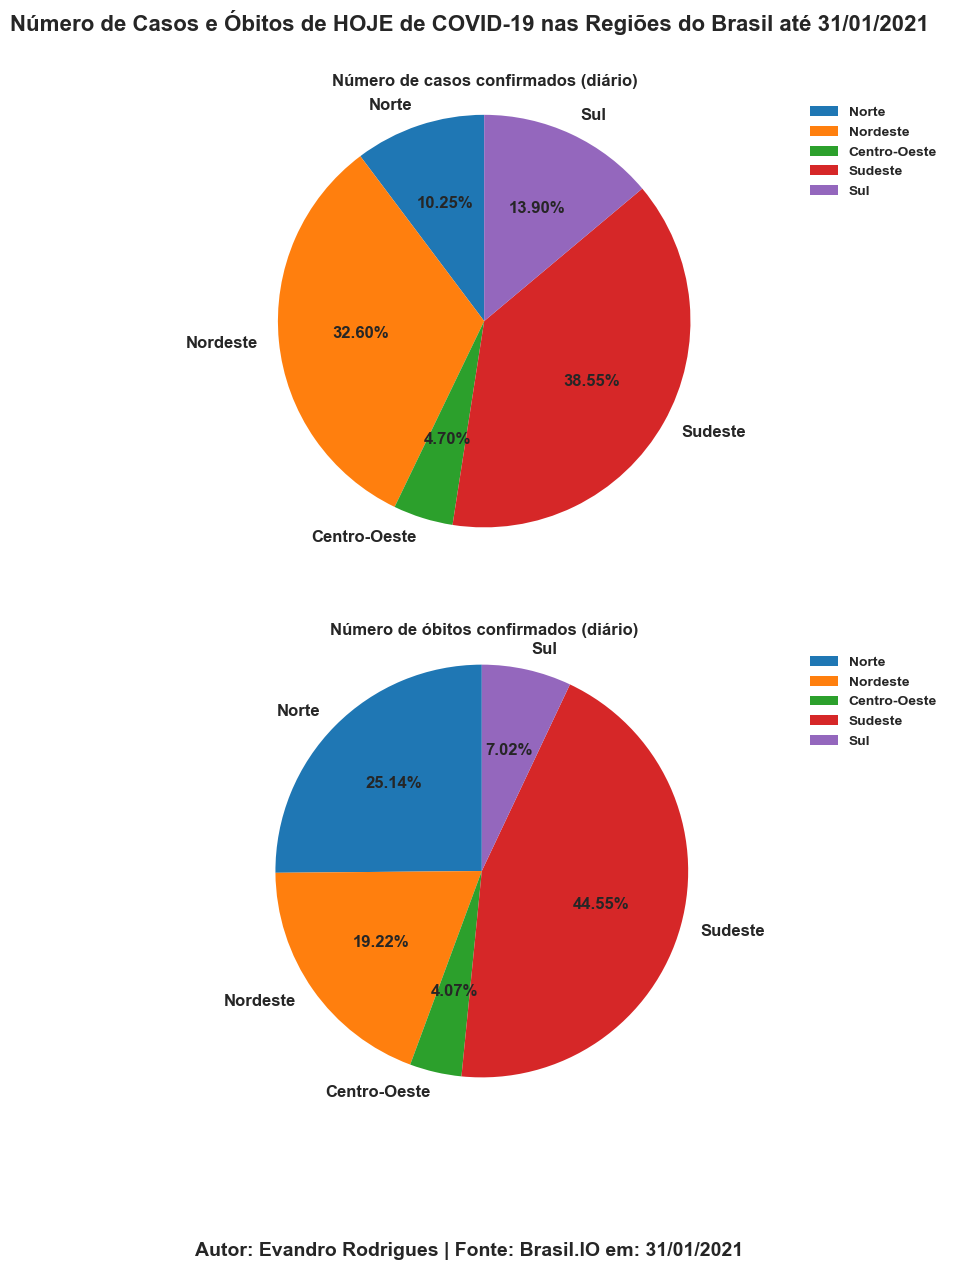

  - Plots generated.

> Returning dataframes.
  - DataFrames returned.

> Generating report
  - Report generated.

Exiting the application.

This script runtime was: 39.23736810684204 seconds ---


In [134]:
# Starting timer
start_time = time.time()

# Running main function
covid_dataset, national_data, regional_data = main()

# Ending and printing the runtime
print("This script runtime was: %s seconds ---" % (time.time() - start_time))